In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchmetrics


In [2]:
torch.manual_seed(42)

# Dataset

In [3]:
progeria = pd.read_csv(r"230705_progeria_c2/progeria_3objs.csv")
normal = pd.read_csv(r"230705_normal_c2/normal_3objs.csv")
cols_to_drop = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
size_based = ["AreaShape_Area","AreaShape_Perimeter", "AreaShape_BoundingBoxArea", "AreaShape_BoundingBoxMaximum_X", "AreaShape_BoundingBoxMaximum_Y", "AreaShape_BoundingBoxMinimum_X", "AreaShape_BoundingBoxMinimum_Y", "AreaShape_ConvexArea", "AreaShape_EquivalentDiameter", "AreaShape_MajorAxisLength", "AreaShape_MinorAxisLength", "AreaShape_MaxFeretDiameter", "AreaShape_MinFeretDiameter", "AreaShape_MaximumRadius", "AreaShape_MeanRadius", "AreaShape_MedianRadius"]
posn_based = ["AreaShape_Center_X", "AreaShape_Center_Y", "Location_Center_X","Location_Center_Y", "Location_Center_Z"]
					
progeria_features = progeria.drop(columns=cols_to_drop + size_based + posn_based)
progeria_features = progeria_features.assign(label=1) 
normal_features = normal.drop(columns=cols_to_drop + size_based + posn_based)
normal_features = normal_features.assign(label=0) 
full_data = pd.concat([progeria_features, normal_features],axis=0)
full_data = full_data.replace([np.inf, -np.inf], np.nan)
full_data = full_data.dropna()
n_cells, n_feats = np.shape(full_data)

In [4]:
class CellFeaturesDataset(Dataset):
    def __init__(self, fulldata, transform=None, target_transform=None):
        self.labels = fulldata.loc[:,'label'].values
        self.data = fulldata.loc[:,~fulldata.columns.isin(['label'])].values
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data[idx,:]
        label = self.labels[idx]
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            label = self.target_transform(label)
        return item.float(), label.float()

## Transform data - scale and convert to tensor

In [5]:
def tensor_and_scale (x):
    m = x.mean(0)
    s = x.std(0)
    x -= m
    x /= s
    # torch.allclose(x, torch.from_numpy(arr_norm))
    return torch.as_tensor(x)

t = tensor_and_scale

In [6]:
cell_dataset = CellFeaturesDataset(full_data, transform=t, target_transform=torch.as_tensor)

## Train-test split, create dataloaders

In [7]:
from sklearn.model_selection import train_test_split

train_cells, test_cells = train_test_split(cell_dataset, stratify=cell_dataset.labels, test_size=0.35, random_state=42)

In [8]:
from collections import Counter

print(Counter([x.item() for x in cell_dataset.labels]))
normal_wt = Counter([x.item() for x in cell_dataset.labels])[0]/len(cell_dataset.labels)
progeria_wt = 1 - normal_wt
print(normal_wt, progeria_wt)

Counter({1: 120, 0: 120})
0.5 0.5


In [9]:
batch_size = 20

#sampler = torchsample.StratifiedSampler(class_vector=cell_dataset.labels, batch_size=batch_size)
#test_cells, train_cells = torch.utils.data.random_split(cell_dataset, [.3, .7])
train_dataloader = DataLoader(train_cells, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_cells, batch_size=batch_size, shuffle=True)

# ANN

In [10]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        # self.flatten = nn.Flatten()
        mid = (n_inputs+n_outputs)//2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=n_outputs),
        )
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)

        #self.linear_relu_stack.apply(init_weights)

    def forward(self, x):
        # do stuff here
        logits = self.linear_relu_stack(x)
        probs = torch.sigmoid(logits)
        return probs

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.float()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long())
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    model.float()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = torch.max(outputs.data, 1)[1]
            print(predicted)
            print(y)
            test_loss += loss_fn(outputs, y.long()).item()
            ncorr = predicted == y
            print(ncorr)
            correct += sum(ncorr)
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    test_loss /= num_batches
    bal_acc /= num_batches
    correct = correct/size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return 100*correct, bal_acc, test_loss

## Run

In [18]:
learning_rate = 1e-2
epochs = 25
loss_fn = nn.NLLLoss(weight=torch.as_tensor([normal_wt, progeria_wt]))
# reg_fn = nn.L1Loss()
model = NeuralNetwork(n_feats-1, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l = train(train_dataloader, model, loss_fn, optimizer)
    a, b_a, t_l = test(test_dataloader, model, loss_fn)
    losses.append(l)
    accs.append(a)
    bal_accs.append(b_a)
    test_losses.append(t_l)
print("Done!")

Epoch 1
-------------------------------
loss: -0.501221  [   20/  156]
loss: -0.490759  [   40/  156]
loss: -0.480186  [   60/  156]
loss: -0.485980  [   80/  156]
loss: -0.500410  [  100/  156]
loss: -0.487500  [  120/  156]
loss: -0.487142  [  140/  156]
loss: -0.487558  [  128/  156]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 1.])
tensor([ True, False,  True, False, False, False, False,  True,  True, False,
        False,  True, False, False, False,  True,  True,  True,  True,  True])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 1.])
tensor([ True, False,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True, False,  True, False,  True,  True, False, False])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

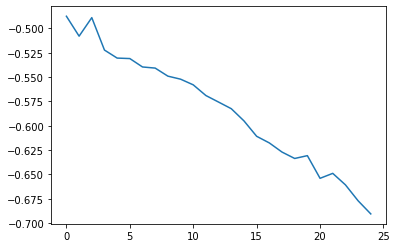

In [19]:
plt.plot(losses)

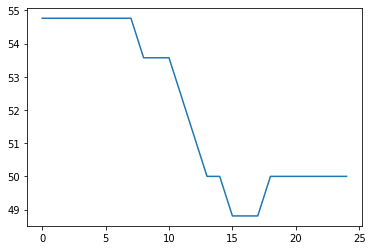

In [20]:
plt.plot(accs)

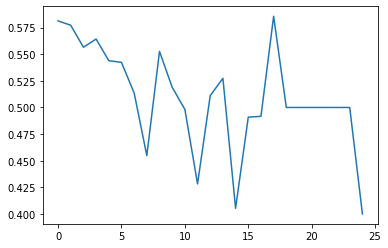

In [21]:
plt.plot(bal_accs)

# Logistic regression

In [22]:
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        torch.nn.init.uniform_(self.linear.weight, -0.01, 0.01) 
        torch.nn.init.zeros_(self.linear.bias)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [23]:
def train (dataloader, model, loss_fn, optimizer, use_closure = False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X)
        outputs = model(X)
        loss = loss_fn(outputs, y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if use_closure:
            def closure():
                optimizer.zero_grad()
                output = model(X)
                loss = loss_fn(output, y.long())
                loss.backward()
                return loss
            optimizer.step(closure)
        current = (batch + 1) * len(X)
        print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(loss.item())
    return loss.item()

In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(y)
            test_loss += loss_fn(outputs, y.long()).item()
            correct += (predicted == y).sum()
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    accuracy = 100 * (correct) / len(dataloader.dataset)
    test_loss /= num_batches
    bal_acc /= num_batches
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return accuracy, bal_acc, test_loss

## Run

In [35]:
log_regr = LogisticRegression(n_feats-1, 2)
# could use BCEWithLogitsLoss and pos_weight
loss_fn = torch.nn.NLLLoss(weight=torch.as_tensor([normal_wt, progeria_wt]))
learning_rate = 1e-2
optimizer = torch.optim.SGD(log_regr.parameters(), lr=learning_rate)
opt2 = torch.optim.Adam(log_regr.parameters(), lr=learning_rate)
epochs = 6

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l_t = train(train_dataloader, log_regr, loss_fn, optimizer)
    a_t, b_a, tl_t = test(test_dataloader, log_regr, loss_fn)
    losses.append(l_t)
    accs.append(a_t)
    bal_accs.append(b_a)
    test_losses.append(tl_t)
print("Done!")

Epoch 1
-------------------------------
loss: -0.499699  [   20/  156]
loss: -0.506701  [   40/  156]
loss: -0.506016  [   60/  156]
loss: -0.516563  [   80/  156]
loss: -0.525898  [  100/  156]
loss: -0.531813  [  120/  156]
loss: -0.538896  [  140/  156]
loss: -0.550459  [  128/  156]
-0.5504586100578308
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 1.])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0.])
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0.])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        1., 1.])
tensor([0, 0, 0, 0])
tensor(

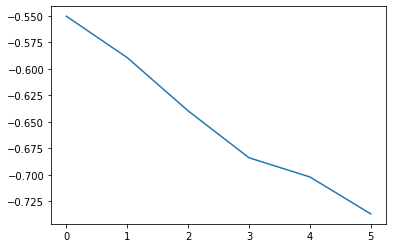

In [36]:
plt.plot(losses)

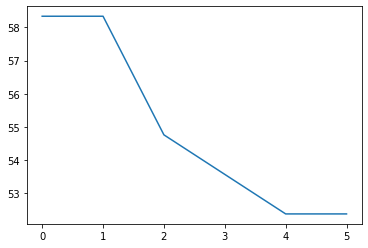

In [37]:
plt.plot(accs)

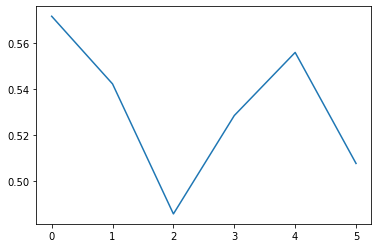

In [38]:
plt.plot(bal_accs)

# Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

X_train = np.asarray([x[0].numpy() for x in train_cells])
y_train = np.asarray([x[1].item() for x in train_cells])

X_test = np.asarray([x[0].numpy() for x in test_cells])
y_test = np.asarray([x[1].item() for x in test_cells])

In [130]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

random_grid = {'n_estimators': list(range(2,200,2)),
               'max_features': [None, 'log2', 'sqrt'],
               'max_depth': list(range(2,10)),
               'bootstrap': [True,False]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=0)
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                          22, 24, 26, 28, 30, 32, 34, 36, 38,
                                          40, 42, 44, 46, 48, 50, 52, 54, 56,
                                          58, 60, ...]})

In [131]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 3, 'max_features': None, 'n_estimators': 50}

In [132]:
clf_base = RandomForestClassifier(n_estimators=22,max_depth=2, criterion="log_loss", random_state=42, class_weight="balanced",bootstrap=True)
clf_base.fit(X_train, y_train)
print(clf_base.score(X_test,y_test))
print(rf_grid.best_estimator_.score(X_test,y_test))

0.6071428571428571
0.5


In [266]:
# https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
